# UCB

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Epsilon-greedy
This function is defined so to compare epsilon greedy with UCB

In [2]:
def epsilon_greedy(n, steps, runs, epsilon, initial, stationary=True, verbose=1, **kwargs):
    """
    args:
        n:           Number of arms in k-armed bandit task
        steps:       Number of time-steps
        runs:        Number of independent runs
        epsilon:     Probability of exploring
        initial:     Initial-values for each action's estimate-value
        stationary:  A boolean that shows if the task stationary
        verbose:     Verbose 0 does not print progress, 1 shows how many runs are completed, 2 shows last avg_reward

    returns:
        mean_rewards at each step
        mean of ratio of optimal actions selected
    """
    # Define estimate action-value
    Q = np.zeros(n) + initial
    # Define N_t(a): number of times each action is taken over a run
    N = np.zeros(n)
    # Define avg_reward: mean rewards observed over all runs
    avg_rewards = np.zeros(steps)
    # Define avg_optimal: mean ratio of optimal ations selected over all runs
    avg_optimal = np.zeros(steps)

    for run in range(runs):
        # reset variables for each run
        q_star = np.random.randn(n)
        Q = np.zeros(n) + initial
        N = np.zeros(n)

        for t in range(steps):
            # take an action
            if np.random.rand() < epsilon:
                A = np.random.choice(n)
            else:
                A = np.argmax(Q)

            # Observe a reward
            R = q_star[A] + np.random.randn()

            # Update estimate action-values
            N[A] += 1
            if 'algorithm' in kwargs and kwargs['algorithm'] == 'sample-average':
                Q[A] = Q[A] + (R - Q[A]) / N[A]
            elif 'algorithm' in kwargs and kwargs['algorithm'] == 'recency-weighted-average':
                alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1
                Q[A] = Q[A] + alpha * (R - Q[A])
            else:
                # Run sample-average method
                Q[A] = Q[A] + (R - Q[A]) / N[A]

            # Average over rewards observed
            avg_rewards[t] += R / runs

            # Average over the ratios of which true actions are selected
            avg_optimal[t] += (1 if A == np.argmax(q_star) else 0) / runs
            
            # Update q_star if not stationary
            if not stationary: q_star = q_star + np.random.randn(n) * 0.01

        if verbose == 1:
            print(f'\rRun {run + 1:>4} out of {runs:>4}', end='')
        elif verbose == 2:
            print(f'\rRun {run + 1:>4} out of {runs:>4} avg_reward: {avg_rewards[steps - 1]:0.3e}', end='')

    return avg_rewards, avg_optimal

## UCB
Instead of using epsilon greedy we choose each action with its upper-confidence-bound; by this we mean that we add a number to each action as its measure of uncertainity;
$$
\begin{gather}
    A_t = \underset{a}{argmax}\bigg[Q_t(a) + c\sqrt{\frac{lnt}{N_t(a)}}\bigg]
\end{gather}
$$

In [3]:
def UCB(n, c, steps, runs, stationary=True, verbose=1, **kwargs):
    """
    args:
        n:           Number of arms in k-armed bandit task
        c:           Confidence level
        steps:       Number of time-isteps
        runs:        Number of independent runs
        stationary:  A boolean that shows if the task stationary
        verbose:     Verbose 0 does not print progress, 1 shows how many runs are completed, 2 shows last avg_reward

    returns:
        mean_rewards at each step
        mean of ratio of optimal actions selected
    """

    # Define a very small value to avoid division by zero
    small = 1e-8
    # Define estimate-value funcitons
    Q = np.zeros(n)
    # Define N_t(a): frequency of each action selected
    N = np.zeros(n)

    # Define average rewards for each step
    avg_rewards = np.zeros(steps)
    # Define average ratio of optimal action selection
    avg_optimal = np.zeros(steps)

    for run in range(runs):
        # reset Q, N and q_star at each run
        q_star = np.random.randn(n)
        N.fill(0)
        Q.fill(0)

        for t in range(steps):
            # Select an action
            lnt = np.log(t) if t > 0 else 1 # This is done to avoid ln(0) or a negative value
            ucb = Q + c * np.sqrt(lnt / (N + small))
            A = np.argmax(ucb)

            # Observe a reward
            R = q_star[A] + np.random.randn()

            # Update estimated action-value
            N[A] += 1
            if 'algorithm' in kwargs and kwargs['algorithm'] == 'sample-average':
                Q[A] = Q[A] + (R - Q[A]) / N[A]
            elif 'algorithm' in kwargs and kwargs['algorithm'] == 'recency-weighted-average':
                alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1
                Q[A] = Q[A] + alpha * (R - Q[A])
            else:
                # Run sample-average method
                Q[A] = Q[A] + (R - Q[A]) / N[A]

            # Average over rewards observed
            avg_rewards[t] += R / runs

            # Average over the ratios of which true actions are selected
            avg_optimal[t] += (1 if A == np.argmax(q_star) else 0) / runs
            
            # Update q_star if not stationary
            if not stationary: q_star = q_star + np.random.randn(n) * 0.01

        if verbose == 1:
            print(f'\rRun {run + 1:>4} out of {runs:>4}', end='')
        elif verbose == 2:
            print(f'\rRun {run + 1:>4} out of {runs:>4} avg_reward: {avg_rewards[steps - 1]:10.3e}', end='')

    return avg_rewards, avg_optimal 

In [4]:
def plot(ax1, ax2, avg_rewards, avg_optimal, label):
    line, = ax1.plot(avg_rewards, label=label)
    ax1.legend(handles=ax1.lines)
    ax1.set_xlabel('time-steps $t$')
    ax1.set_ylabel('average rewards')
    ax1.set_title('Average rewards observed at each time-step');
    
    line, = ax2.plot(avg_optimal * 100, label=label)
    ax2.legend(handles=ax2.lines, loc='best')
    ax2.set_xlabel('time-steps $t$')
    ax2.set_ylabel('%optimal action taken')
    ax2.set_title('Optimal action taken at each time-step');
    ax2.set_ylim([0, 100]);
    ax2.set_yticks(range(0, 101, 20));
    ax2.set_yticklabels(['%' + str(x) for x in range(0, 101, 20)]);

Run 1000 out of 1000 avg_reward: 1.313e+000

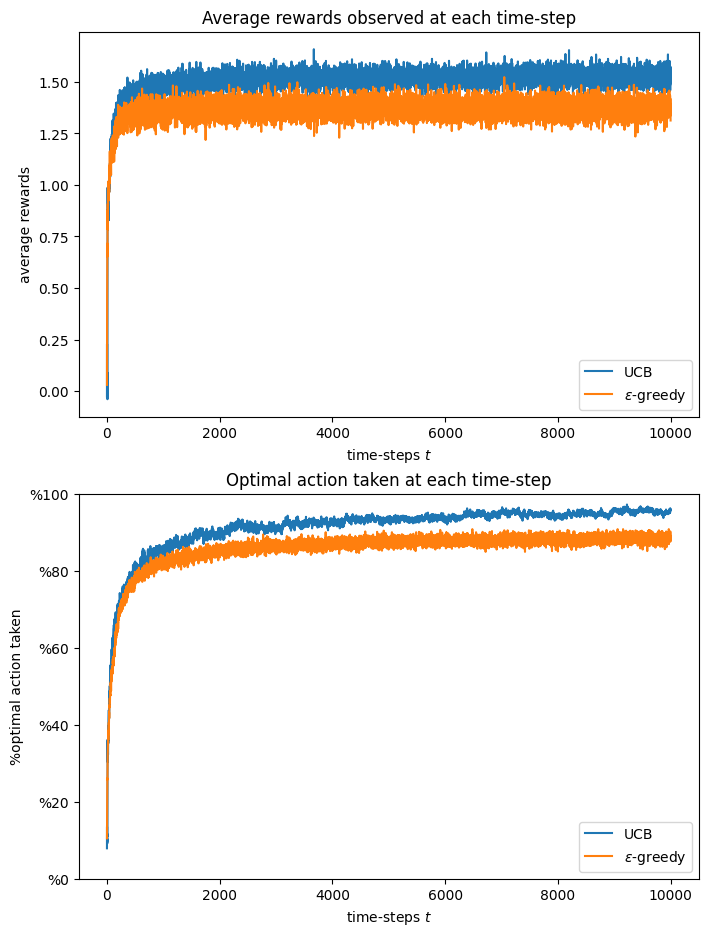

In [5]:
n = 10                             # Number of arms in k-armed bandit task
steps = 10000                      # Number of time-steps
runs = 1000                        # Number of independent runs
epsilon = 0.1                      # Probability of exploring
c = 2                              # Confidence level

ucb_rewards, ucb_optimal = UCB(n, c, steps, runs, verbose=2)
epsilon_rewards, epsilon_optimal = epsilon_greedy(n, steps, runs, epsilon, 0, verbose=2)

fig = plt.figure(figsize=(8, 11))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)
plot(ax1, ax2, ucb_rewards, ucb_optimal, label='UCB')
plot(ax1, ax2, epsilon_rewards, epsilon_optimal, label='$\epsilon$-greedy')